__Creation of NEXD-2D mesh for Lambs problem__

Daniel Koehn

Kiel, 23.02.2018

based on code provided by ...

... Liu Benyuan in https://github.com/inducer/meshpy/pull/11

__Load libs__

In [1]:
from __future__ import division

import meshpy.triangle as triangle
import numpy as np
import matplotlib.pyplot as plt

__trip connect points__

In [2]:
def round_trip_connect(start, end):
    return [(i, i+1) for i in range(start, end)] + [(end, start)]

__Triangle refinement function__

In [3]:
def refinement_func(tri_points, area):
    max_area=2000.0
    min_area=2000.0
    #max_area=800000.0
    #min_area=800000.0    
    return bool(area>max_area);

__Write mesh point coordinates__

In [4]:
def coord_write(mesh_points, coord_name):
    ''' write nodes file '''
    coord=open(coord_name,'w')
    print('writing '+coord_name)
    ncoord=len(mesh_points)
    print('number of nodes:',str(ncoord))
    # write ncoord
    coord.write('%10i\n' % ncoord)
    # write coords
    for node in range(0,ncoord,1):           
        txt=('%10i %20f %20f\n') % (node+1,mesh_points[node,0],mesh_points[node,1])
        coord.write(txt)
    coord.close()
    print('Ok')

__Write element file__

In [5]:
def elem_write(mesh_tris,mesh_name):
    meshfile=open(mesh_name,'w')
    print('Writing '+mesh_name+'.....')
    nelem=len(mesh_tris)
    print('number of elements:',str(nelem))
    meshfile.write(str(nelem)+'\n')
    for tri in range(0,nelem,1):
        txt=('%10i %10i %10i %10i\n') % (tri+1,mesh_tris[tri,0]+1,mesh_tris[tri,1]+1,mesh_tris[tri,2]+1)
        meshfile.write(txt)
    meshfile.close()
    print('Ok')

__Write Matprop file__

In [6]:
def matprop_write(matprop_name):
    matpropfile=open(matprop_name,'w')
    print('Writing '+matprop_name+'.....')
    print('number of material parameters:',str(1))
    matpropfile.write(str(1)+'\n')
    txt=('%10i %10i %10f %10f %10f %10f %10f\n') % (1,1,vp,vs,rho,qp,qs)
    matpropfile.write(txt)
    matpropfile.close()

__Write Mat file__

In [7]:
def mat_write(mesh_tris,mat_name):
    mat=open(mat_name,'w')
    print('Writing '+mat_name+'.....')
    nelem= len(mesh_tris)
    for i in range(nelem):
        mat.write(('%10i %10i %10i\n') % (i+1,1,0))
    mat.close()
    print('Ok')

__Write Free Surface file__

In [8]:
def free_write(mesh_tris,mesh_free,free_name):
    
    freefile=open(free_name,'w')
    print('writing '+free_name)
    
    # count number of free surface elements
    nfree_surf = len(mesh_free)    
    nfree = 0
    for n in range(nfree_surf):
        if(mesh_free[n]==1):
            nfree+=1 
            
    print('Number of free surface boundary nodes ',nfree)
    
    # write absorbing boundary elements
    freefile.write(str(nfree)+'\n')
    for n in range(nfree_surf):
        if(mesh_free[n]==1):
            freefile.write(('%10i \n') % (n+1))            
    freefile.close()
    print('Ok')

__Write Absorb file__

In [9]:
def absorb_write(mesh_tris,mesh_absorb,absorb_name):
        
    absorbfile=open(absorb_name,'w')
    print('writing '+absorb_name)
    
    # count number of free surface elements
    nabsorb = len(mesh_absorb)    
    nabs = 0
    for n in range(nabsorb):
        if(mesh_absorb[n]==1):
            nabs+=1 
            
    print('Number of absorbing boundary nodes ',nabs)
    
    # write absorbing boundary elements
    absorbfile.write(str(nabs)+'\n')
    for n in range(nabsorb):
        if(mesh_absorb[n]==1):
            absorbfile.write(('%10i \n') % (n+1))            
    absorbfile.close()
    print('Ok')

__Define Lambs problem__

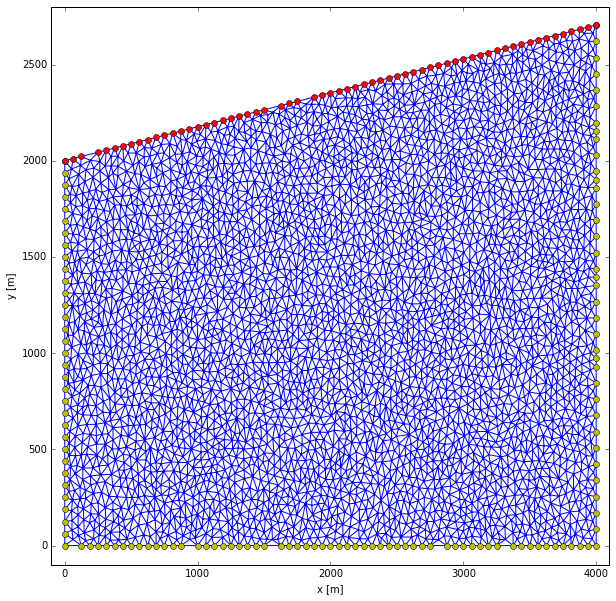

In [10]:
points = [(0, 0), (4000, 0), (4000, 2705.31), (0, 2000)]
facets = round_trip_connect(0, len(points)-1)
markers = [2,2,2,2]

# define visco-elastic material parameters
vp = 3200 
vs = 1847.5 
rho = 2200 
qp = 9999 
qs = 9999

# create points and mesh using TRIANGLE
info = triangle.MeshInfo()
info.set_points(points)
info.set_facets(facets, facet_markers=markers)
 
mesh = triangle.build(info, refinement_func=refinement_func)
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_attr = np.array(mesh.point_markers)
mesh_free = np.array(mesh.point_markers)
mesh_absorb = np.array(mesh.point_markers)

# estimate nodes with absorbing boundary condition
xpml1 = 0
xpml2 = 4000
ypml1 = 0
nnodes = len(mesh_free)
for n in range(nnodes):
    mesh_absorb[n] = 0
    if((mesh_points[n,0]==xpml1) or (mesh_points[n,0]==xpml2) or (mesh_points[n,1]==ypml1)):
        mesh_absorb[n] = 1
        
# estimate nodes with free surface boundary condition
for n in range(nnodes):
    mesh_free[n] = 0
    
    # all boundary nodes which not coincide with mesh_absorb ...
    if((mesh_attr[n]==2) and (mesh_absorb[n]!=1)):
        mesh_free[n] = 1
    
    # ... except for the upper left and right corner node
    if((mesh_points[n,0]==xpml1) and (mesh_points[n,1]==points[3][1])):        
        mesh_free[n] = 1
    if((mesh_points[n,0]==xpml2) and (mesh_points[n,1]==points[2][1])):        
        mesh_free[n] = 1        
        
#print(mesh_tris)

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

n = np.size(mesh_attr)

absorb_nodes = [i for i in range(n) if mesh_absorb[i]==1]
plt.plot(mesh_points[absorb_nodes, 0], mesh_points[absorb_nodes, 1], 'yo')
       
free_nodes = [i for i in range(n) if mesh_free[i]==1]
plt.plot(mesh_points[free_nodes, 0], mesh_points[free_nodes, 1], 'ro')

plt.axis([-100, 4100, -100, 2800.0])

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.savefig('meshpy-lamb.pdf')
plt.show()

__Write NEXD-2D files__

In [11]:
# define names of NEXD-2D output files
coord_name = 'coord'
mesh_name = 'mesh'
matprop_name = 'matprop'
mat_name = 'mat'
free_name = 'free'
absorb_name = 'absorb'

coord_write(mesh_points,coord_name)
matprop_write(matprop_name)
mat_write(mesh_tris,mat_name)
elem_write(mesh_tris,mesh_name)
free_write(mesh_tris,mesh_free,free_name)
absorb_write(mesh_tris,mesh_absorb,absorb_name)

writing coord
number of nodes: 3777
Ok
Writing matprop.....
number of material parameters: 1
Writing mat.....
Ok
Writing mesh.....
number of elements: 7364
Ok
writing free
Number of free surface boundary nodes  62
Ok
writing absorb
Number of absorbing boundary nodes  128
Ok
